In [23]:
%load_ext autoreload
%autoreload 2

from dynamics import *

import torch.nn as nn
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
class DotProduct(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.pow(x, 2).sum(dim=1)

# siamese network
class EBM(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        
        self.phi = nn.Sequential(
            nn.Linear(input_shape, 4*input_shape),
            nn.ReLU(),
            nn.Linear(4*input_shape, 8*input_shape),
            nn.ReLU(),
            nn.Linear(8*input_shape, 16*input_shape),
            nn.ReLU(),
            nn.Linear(16*input_shape, 16*input_shape),
            DotProduct()
        )

    def forward(self, x):
        return self.phi(x)

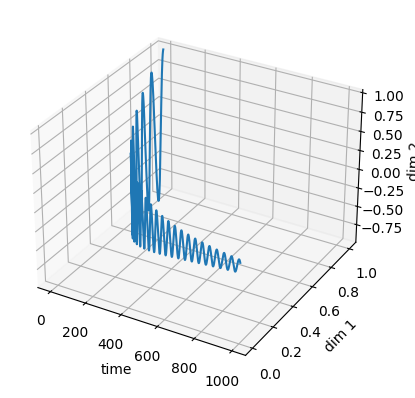

In [29]:
x = dampened_oscillator(m=1.0, c=np.array([100.0, 0.1]), k=np.array([10.0, 10.0]))

plot_3d(x.cpu().numpy())

In [30]:
def positive_term_loss(batch):
    margin = 2

    x_t = batch[:-1, :]
    x_tp1 = batch[1:, :]

    E_x_t = model(x_t)
    E_x_tp1 = model(x_tp1)

    loss = torch.mean(torch.maximum(torch.zeros(x_t.shape[0]).cuda(), margin + (E_x_tp1 - E_x_t))**2)

    # loss = torch.mean(torch.exp(E_x_tp1 - E_x_t))

    return loss


def negative_term_loss(batch, num_negative_samples):
    margin = 2
    beta = 1

    x_t = batch[:-1, :]

    losses = 0

    for sample in x_t:
        E_x_t = model(sample.unsqueeze(0)).repeat(num_negative_samples)
        E_x_tp1 = model(generate_negative_samples(sample, angle=30, num_samples=num_negative_samples))
        
        # loss = torch.sum(torch.maximum(torch.zeros(num_negative_samples), margin - (E_x_tp1 - E_x_t))**2)

        loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * (E_x_tp1 - E_x_t))))

        # loss = torch.sum(torch.exp(-(E_x_tp1 - E_x_t)))

        losses += loss

    losses /= x_t.shape[0]

    return losses    

In [31]:
def epoch(iterations, bs, num_negative_samples):
    losses = []

    for i in tqdm(range(iterations)):
        batch = generate_batch(x, bs=bs)

        optimizer.zero_grad()

        loss = positive_term_loss(batch) + negative_term_loss(batch, num_negative_samples=num_negative_samples)

        loss.backward()

        optimizer.step()

        losses.append(loss.detach().cpu().item())

    print(np.mean(losses))

In [33]:
#model = EBM(2).cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for e in range(10):
    epoch(iterations=20, bs=100, num_negative_samples=20)

100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


1.4103461742401122


100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


1.521699810028076


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


2.3397068619728087


100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


1.176247489452362


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


1.4120718955993652


 40%|████      | 8/20 [00:03<00:05,  2.13it/s]


KeyboardInterrupt: 